In [1]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import sys
import numpy
from functools import reduce

try:
    from . SpatialCrossMapLRN_temp import SpatialCrossMapLRN_temp
except:
    from SpatialCrossMapLRN_temp import SpatialCrossMapLRN_temp

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict


Populating the interactive namespace from numpy and matplotlib


In [2]:
class LambdaBase(nn.Sequential):
    def __init__(self, fn, *args):
        super(LambdaBase, self).__init__(*args)
        self.lambda_func = fn

    def forward_prepare(self, input):
        output = []
        for module in self._modules.values():
            output.append(module(input))
        return output if output else input

class Lambda(LambdaBase):
    def forward(self, input):
        return self.lambda_func(self.forward_prepare(input))

class LambdaMap(LambdaBase):
    def forward(self, input):
        return list(map(self.lambda_func,self.forward_prepare(input)))

class LambdaReduce(LambdaBase):
    def forward(self, input):
        return reduce(self.lambda_func,self.forward_prepare(input))

#
def Conv2d(in_dim, out_dim, kernel, stride, padding):
    l = torch.nn.Conv2d(in_dim, out_dim, kernel, stride=stride, padding=padding)
    return l

def BatchNorm(dim):
    l = torch.nn.BatchNorm2d(dim)
    return l

def CrossMapLRN(size, alpha, beta, k=1.0, gpuDevice=0):
    lrn = SpatialCrossMapLRN_temp(size, alpha, beta, k, gpuDevice=gpuDevice)
    n = Lambda( lambda x,lrn=lrn: Variable(lrn.forward(x.data).cuda(gpuDevice)) if x.data.is_cuda else Variable(lrn.forward(x.data)) )
    return n

def Linear(in_dim, out_dim):
    l = torch.nn.Linear(in_dim, out_dim)
    return l


class Inception(nn.Module):
    def __init__(self, inputSize, kernelSize, kernelStride, outputSize, reduceSize, pool, useBatchNorm, reduceStride=None, padding=True):
        super(Inception, self).__init__()
        #
        self.seq_list = []
        self.outputSize = outputSize

        #
        # 1x1 conv (reduce) -> 3x3 conv
        # 1x1 conv (reduce) -> 5x5 conv
        # ...
        for i in range(len(kernelSize)):
            od = OrderedDict()
            # 1x1 conv
            od['1_conv'] = Conv2d(inputSize, reduceSize[i], (1, 1), reduceStride[i] if reduceStride is not None else 1, (0,0))
            if useBatchNorm:
                od['2_bn'] = BatchNorm(reduceSize[i])
            od['3_relu'] = nn.ReLU()
            # nxn conv
            pad = int(numpy.floor(kernelSize[i] / 2)) if padding else 0
            od['4_conv'] = Conv2d(reduceSize[i], outputSize[i], kernelSize[i], kernelStride[i], pad)
            if useBatchNorm:
                od['5_bn'] = BatchNorm(outputSize[i])
            od['6_relu'] = nn.ReLU()
            #
            self.seq_list.append(nn.Sequential(od))

        ii = len(kernelSize)
        # pool -> 1x1 conv
        od = OrderedDict()
        od['1_pool'] = pool
        if ii < len(reduceSize) and reduceSize[ii] is not None:
            i = ii
            od['2_conv'] = Conv2d(inputSize, reduceSize[i], (1,1), reduceStride[i] if reduceStride is not None else 1, (0,0))
            if useBatchNorm:
                od['3_bn'] = BatchNorm(reduceSize[i])
            od['4_relu'] = nn.ReLU()
        #
        self.seq_list.append(nn.Sequential(od))
        ii += 1

        # reduce: 1x1 conv (channel-wise pooling)
        if ii < len(reduceSize) and reduceSize[ii] is not None:
            i = ii
            od = OrderedDict()
            od['1_conv'] = Conv2d(inputSize, reduceSize[i], (1,1), reduceStride[i] if reduceStride is not None else 1, (0,0))
            if useBatchNorm:
                od['2_bn'] = BatchNorm(reduceSize[i])
            od['3_relu'] = nn.ReLU()
            self.seq_list.append(nn.Sequential(od))

        self.seq_list = nn.ModuleList(self.seq_list)


    def forward(self, input):
        x = input

        ys = []
        target_size = None
        depth_dim = 0
        for seq in self.seq_list:
            #print(seq)
            #print(self.outputSize)
            #print('x_size:', x.size())
            y = seq(x)
            y_size = y.size()
            #print('y_size:', y_size)
            ys.append(y)
            #
            if target_size is None:
                target_size = [0] * len(y_size)
            #
            for i in range(len(target_size)):
                target_size[i] = max(target_size[i], y_size[i])
            depth_dim += y_size[1]

        target_size[1] = depth_dim
        #print('target_size:', target_size)

        for i in range(len(ys)):
            y_size = ys[i].size()
            pad_l = int((target_size[3] - y_size[3]) // 2)
            pad_t = int((target_size[2] - y_size[2]) // 2)
            pad_r = target_size[3] - y_size[3] - pad_l
            pad_b = target_size[2] - y_size[2] - pad_t
            ys[i] = F.pad(ys[i], (pad_l, pad_r, pad_t, pad_b))

        output = torch.cat(ys, 1)

        return output


class netOpenFace(nn.Module):
    def __init__(self, gpuDevice=0):
        super(netOpenFace, self).__init__()

        self.gpuDevice = gpuDevice
        
        self.layer1 = Conv2d(3, 64, (7,7), (2,2), (3,3))
        self.layer2 = BatchNorm(64)
        self.layer3 = nn.ReLU()
        self.layer4 = nn.MaxPool2d((3,3), stride=(2,2), padding=(1,1))
        self.layer5 = CrossMapLRN(5, 0.0001, 0.75, gpuDevice=gpuDevice)
        self.layer6 = Conv2d(64, 64, (1,1), (1,1), (0,0))
        self.layer7 = BatchNorm(64)
        self.layer8 = nn.ReLU()
        self.layer9 = Conv2d(64, 192, (3,3), (1,1), (1,1))
        self.layer10 = BatchNorm(192)
        self.layer11 = nn.ReLU()
        self.layer12 = CrossMapLRN(5, 0.0001, 0.75, gpuDevice=gpuDevice)
        self.layer13 = nn.MaxPool2d((3,3), stride=(2,2), padding=(1,1))
        self.layer14 = Inception(192, (3,5), (1,1), (128,32), (96,16,32,64), nn.MaxPool2d((3,3), stride=(2,2), padding=(0,0)), True)
        self.layer15 = Inception(256, (3,5), (1,1), (128,64), (96,32,64,64), nn.LPPool2d(2, (3,3), stride=(3,3)), True)
        self.layer16 = Inception(320, (3,5), (2,2), (256,64), (128,32,None,None), nn.MaxPool2d((3,3), stride=(2,2), padding=(0,0)), True)
        self.layer17 = Inception(640, (3,5), (1,1), (192,64), (96,32,128,256), nn.LPPool2d(2, (3,3), stride=(3,3)), True)
        self.layer18 = Inception(640, (3,5), (2,2), (256,128), (160,64,None,None), nn.MaxPool2d((3,3), stride=(2,2), padding=(0,0)), True)
        self.layer19 = Inception(1024, (3,), (1,), (384,), (96,96,256), nn.LPPool2d(2, (3,3), stride=(3,3)), True)
        self.layer21 = Inception(736, (3,), (1,), (384,), (96,96,256), nn.MaxPool2d((3,3), stride=(2,2), padding=(0,0)), True)
        self.layer22 = nn.AvgPool2d((3,3), stride=(1,1), padding=(0,0))
        self.layer25 = Linear(736, 128)

        #
        self.resize1 = nn.UpsamplingNearest2d(scale_factor=3)
        self.resize2 = nn.AvgPool2d(4)

    def forward(self, input, out_keys):
        x = input
        out = {}

        if x.data.is_cuda and self.gpuDevice != 0:
            x = x.cuda(self.gpuDevice)

        #
        if x.size()[-1] == 128:
            x = self.resize2(self.resize1(x))

        out['l1'] = self.layer8(self.layer7(self.layer6(self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x))))))))
        out['l2'] = self.layer13(self.layer12(self.layer11(self.layer10(self.layer9(out['l1'])))))
        out['l3'] = self.layer14(out['l2'])
        out['l4'] = self.layer15(out['l3'])
        out['l5'] = self.layer16(out['l4'])
        out['l6'] = self.layer17(out['l5'])
        out['l7'] = self.layer18(out['l6'])
        out['l8'] = self.layer19(out['l7'])
        out['l9'] = self.layer21(out['l8'])
        out['l10'] = self.layer22(out['l9'])
        out['l11'] = out['l10'].view((-1, 736))

        return [out[key] for key in out_keys]
print("done")

done


In [3]:
class Vgg_vd_face_fer_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_fer_dag, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(4096, 4096)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(4096, 7)
        self.fc8.bias.requires_grad = False
        self.fc8.bias.unsqueeze_(0)

    def forward(self, input, out_keys):
        
        out = {}
        
        out['r11'] = self.relu1_1(self.conv1_1(input))
        out['r12'] = self.relu1_2(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = self.relu2_1(self.conv2_1(out['p1']))
        out['r22'] = self.relu2_2(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = self.relu3_1(self.conv3_1(out['p2']))
        out['r32'] = self.relu3_2(self.conv3_2(out['r31']))
        out['r33'] = self.relu3_3(self.conv3_3(out['r32']))
        out['p3'] = self.pool3(out['r33'])
        out['r41'] = self.relu4_1(self.conv4_1(out['p3']))
        out['r42'] = self.relu4_2(self.conv4_2(out['r41']))
        out['r43'] = self.relu4_3(self.conv4_3(out['r42']))
        out['p4'] = self.pool4(out['r43'])
        out['r51'] = self.conv5_1(self.relu5_1(out['p4']))
        out['r52'] = self.conv5_2(self.relu5_2(out['r51']))
        out['r53'] = self.conv5_3(self.relu5_3(out['r52']))
        out['p5'] = self.pool5(out['r53'])
        out['fc6'] = self.fc6(self.relu6(out['p5']))
        #out['fc7'] = self.fc7(self.relu7(out['fc6']))
        #out['fc8'] = self.fc8(out['fc7'])
        
        return [out[key] for key in out_keys]
    
    print("done")

done


In [4]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=np.array([129.186279296875, 104.76238250732422, 93.59396362304688])/255, #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=np.array([-129.186279296875, -104.76238250732422, -93.59396362304688])/255, #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

print("done")

done


/home/student5/anaconda2/lib/python2.7/site-packages/torchvision-0.2.1-py2.7.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [5]:
#get facial recognition network
openFace = netOpenFace()
openFace.load_state_dict(torch.load(model_dir + 'openface.pth'))
for param in openFace.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    openFace.cuda()

#get network
fer = Vgg_vd_face_fer_dag()
fer.load_state_dict(torch.load(model_dir + 'vgg_vd_face_fer_dag.pth'))
for param in fer.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    fer.cuda()
    
print("done")

done


In [6]:
#load images, ordered as [expression_image, identity_image]
img_dirs = [image_dir, image_dir]
img_names = ['Alec_Baldwin_0002.jpg', 'Allan_Wagner_0001.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
expression_image, identity_image = imgs_torch

# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
expression_image.resize_(identity_image.size())
opt_img = Variable(identity_image.data.clone(), requires_grad=True)

print("done")

done


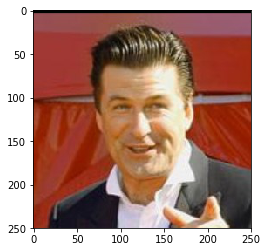

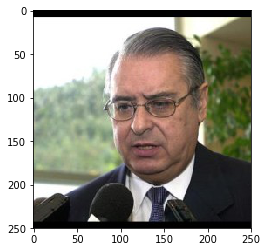

In [7]:
#display images
for img in imgs:
    imshow(img);show()

In [8]:
#define layers, loss functions, weights and compute optimization targets
expression_layers = ['r11','r21','r31','r41','r51']
identity_layers = ['l1','l2','l3','l4','l5','l6','l7','l8','l9']

loss_expression = [nn.MSELoss()] * len(expression_layers)
loss_identity = [nn.MSELoss()] * len(identity_layers)
if torch.cuda.is_available():
    loss_expression = [loss_fn.cuda() for loss_fn in loss_expression]
    loss_identity = [loss_fn.cuda() for loss_fn in loss_identity]
    
#these are good weights settings:
#expression_weights = [1e0/n**2 for n in [64,128,256,512,512]]
expression_weights = [0.001,0.001,0.001,0.001,0.001]
identity_weights = [1,1,1,1,1,1,1,1,1]*1000000000

#compute optimization targets
expression_targets = [A.detach() for A in fer(expression_image, expression_layers)]
identity_targets = [A.detach() for A in openFace(identity_image, identity_layers)]


print("done")

done


In [ ]:
#run expression transfer
max_iter = 1000
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        expression_out = fer(opt_img, expression_layers)
        expression_losses = [expression_weights[a] * loss_expression[a](A, expression_targets[a]) for a,A in enumerate(expression_out)]
        identity_out = openFace(opt_img, identity_layers)
        identity_losses = [identity_weights[a] * loss_identity[a](A, identity_targets[a]) for a,A in enumerate(identity_out)]
        layer_losses = expression_losses + identity_losses
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data[0]))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

/home/student5/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 50, loss: 159.775375
Iteration: 100, loss: 5.172734
Iteration: 150, loss: 2.868515
Iteration: 200, loss: 2.319465
Iteration: 250, loss: 2.071083
Iteration: 300, loss: 1.919994
Iteration: 350, loss: 1.832009
Iteration: 400, loss: 1.767920
Iteration: 450, loss: 1.724122
Iteration: 500, loss: 1.689769
Iteration: 550, loss: 1.664970
Iteration: 600, loss: 1.644073
Iteration: 650, loss: 1.627366
